In [1]:
# importujemy przydatne skladowe biblioteki pomagajacej w uczeniu sieci neuronowych
import keras
import keras.applications.mobilenet_v2 as k_mobilenet_v2
import keras.backend as k
import keras.datasets.mnist as k_mnist
import keras.layers as k_layers
import keras.losses as k_losses
import keras.models as k_models
import keras.optimizers as k_optimizers
import keras.preprocessing.image as k_image
import keras.utils as k_utils
from keras.layers import Dense

# importujemy biblioteke pomagajaca w rysowaniu wykresow i wizualizacji
import matplotlib.pyplot as plt

# importujemy biblioteke pomagajaca w obliczeniach numerycznych
import numpy as np

# importujemy biblioteke pomagajaca nam w operacjach tensorowych (niezbedna do poczatkowych cwiczen)
import tensorflow as tf

from math import ceil

Using TensorFlow backend.


In [2]:
# ladujemy przykladowe dane wejsciowe (klasyczny juz zbior danych z recznie pisanymi cyframi)
data = k_mnist.load_data()
# korzystamy z gotowego podziału na czesc treningowa i testowa
(train_images, train_labels), (test_images, test_labels) = data
# ustalamy rozmiar jednej paczki danych uczacych na 100 przykladow - pozwala to efektywniej uzywac CPU/GPU
batch_size = 100


# funkcja pomocnicza inicjujaca i zwracajaca sesje obliczeniowa TensorFlow
def _init_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    init = tf.global_variables_initializer()
    session.run(init)
    return session


# funkcja pomocnicza odpowiedzialna za uczenie (optymalizacje) z uzyciem spadku po gradiencie
def _optimise(session, x, correct_y, loss):
    # przygotowujemy silnik optymalizujacy (w tym przypadku oparty o wspomniany spadek po gradiencie)
    optimizer = tf.train.GradientDescentOptimizer(0.5)
    # 0.5 to stala regulujaca szybkosc spadku, a wiec tez uczenia, zazwyczaj nazywana learning rate
    train_step = optimizer.minimize(loss)  # informujemy, ze tym co chcemy zredukowac jest wlasnie L (loss)

    # porcjujemy nasze dane treningowe na paczki do rownoczesnego wykorzystania - to przyspieszy proces uczenia
    for i in range(train_images.shape[0] // batch_size):
        batch_train_images = train_images[i * batch_size:(i + 1) * batch_size, :, :]
        batch_train_labels = train_labels[i * batch_size:(i + 1) * batch_size]
        # elementy podane do feed_dict zapelniaja stworzone wczesniej placeholdery na dane
        session.run(train_step, feed_dict={x: batch_train_images, correct_y: batch_train_labels})


# funkcja pomocnicza odpowiedzialna za weryfikacje skutecznosci wytrenowanej sieci
def _test_accuracy(session, x, correct_y, y, y_):
    # definiujemy praiwdlowy wynik: wtedy gdy najwieksze prawdopodobienstwo ma wlasciwa klasa
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    # definiujemy skutecznosc jako srednia ilosc prawidlowych wynikow
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # uruchamiamy obliczenia, tym razem sprawdzajac, nie uczac (zwroc uwage na inny argument session.run
    test_outcome = session.run(accuracy, feed_dict={x: test_images, correct_y: test_labels})
    print("Final accuracy result: {0} %".format(test_outcome * 100.0))


def intro():
    # obejrzyjmy przykladowy element zbioru - cyfre 3
    example_image = train_images[32]
    # upewnijmy sie, ze to co widzimy jest zgodne z przyporzadkowana klasa
    example_label = train_labels[32]
    print("Correct label for this element: {0}".format(example_label))
    # wyplotujmy zawartosc obrazu
    plt.imshow(example_image)
    plt.show()
    # TODO: sprawdz co zawiera kilka innych elementow; czy sa latwe do rozpoznania dla czlowieka?


def f(x, w, b):
    return tf.nn.softmax(tf.matmul(x, w) + b)


def exercise_one():
    # tworzymy nasza pierwsza, minimalna siec

    # tf.placeholder to miejsce na tensor, ktory zostanie zawsze podany przed startem obliczen i nigdy sie nie zmieni
    # z jego uzyciem najpierw przygotowujemy miejsca na wejsciowy obraz...
    # w tym przypadku nie zastepujemy None - oznaczaja one dowolny rozmiar
    x = tf.placeholder(tf.float32, [None, 28, 28])  # miejsce na obraz cyfry (28px na 28px)
    x_ = tf.reshape(x, [-1, 784])  # reshape do liniowego ksztaltu (28x28=784), -1 to automatyczne dopasowanie reszty
    x_ /= 255.0  # podzielenie przez 255.0 normalizuje wartosci do zakresu od 0.0 do 1.0
    # ...oraz etykiete oznaczajaca cyfre, jaka przedstawia
    correct_y = tf.placeholder(tf.uint8, [None])  # miejsce na klase cyfry (mozliwe 10 roznych klas)
    y_ = tf.one_hot(correct_y, 10)  # zamienia cyfrę na wektor o 10 pozycjach, tylko jedna z nich jest inna niz 0 (hot)

    # potem przygotowujemy zmienne - tensory ktorych wartosci beda ewoluowac w czasie
    # inicjujemy je zerami o wlasciwym ksztalcie - tu wlasnie znajda sie poszukiwane przez nas optymalne wagi
    w = tf.Variable(tf.zeros([784, 10]))  # wagi funkcji liniowej (10 neuronow, kazdy ma 784 wejscia)
    b = tf.Variable(tf.zeros([10]))  # bias funkcji liniowej (dla kazdego z 10 neuronow)

    # TODO: zastap None, zaimplementuj funkcje f
    # wykorzystaj przygotowane wyzej zmienne oraz tf.matmul i tf.nn.softmax
    y = f(x_, w, b)

    # TODO: zastap None, dokoncz implementacje funkcji L (entropii krzyzowej)
    # wykorzystaj przygotowane wyzej zmienne oraz tf.log; zastanow sie jak zsumowac tylko wlasciwe elementy wyjscia!
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(tf.multiply(y_, tf.log(y)), reduction_indices=[1]))

    # uruchamiamy graf obliczen tensor flow
    session = _init_session()  # startujemy sesje
    _optimise(session, x, correct_y, cross_entropy)  # optymalizujemy entropie krzyzowa
    _test_accuracy(session, x, correct_y, y, y_)  # i weryfikujemy skutki na danych testowych
    # TODO: jaki wynik udalo sie uzyskac?
    # 90.53000211715698 %


def exercise_two():
    # dodajemy do naszej sieci dodatkowa warstwe, w celu zwiekszenia jej pojemnosci i sily wyrazu

    # ta sekcja jest powtorka z poprzedniego cwiczenia - rozstawia warstwe wejsciowa
    x = tf.placeholder(tf.float32, [None, 28, 28])
    x_ = tf.reshape(x, [-1, 784]) / 255.0
    correct_y = tf.placeholder(tf.uint8, [None])
    y_ = tf.one_hot(correct_y, 10)

    # kolejne dwie sekcje nieco sie juz roznia - dodalismy dodatkowa warstwe wewnetrzna
    w1 = tf.Variable(tf.zeros([784, 100]))
    b1 = tf.Variable(tf.zeros([100]))
    h1 = None

    w2 = tf.Variable(tf.zeros([100, 10]))
    b2 = tf.Variable(tf.zeros([10]))

    y1 = tf.nn.relu(tf.matmul(x_, w1) + b1)
    y = tf.nn.softmax(tf.matmul(y1, w2) + b2)
    # TODO: zastap None, zaimplementuj aktywacje obu warstw wzorujac sie na exercise_one
    # dla pierwszej warstwy skorzystaj z tf.nn.relu, dla drugiej (wyjsciowej) nadal z tf.nn.softmax

    cross_entropy = tf.reduce_mean(-tf.reduce_sum(tf.multiply(y_, tf.log(y)), reduction_indices=[1]))
    # TODO: wykorzystaj powyzej implementacje z exercise_one (jest nadal aktualna)

    # ta sekcja rowniez jest powtorka z poprzedniego cwiczenia
    session = _init_session()
    _optimise(session, x, correct_y, cross_entropy)
    _test_accuracy(session, x, correct_y, y, y_)
    # TODO: jaki wynik udalo sie tym razem uzyskac? czy zaskoczyl cie?
    # 10.279999673366547 %


def exercise_three():
    # TODO: rozwiaz problem z poczatkowymi aktywacjami funkcji ReLU
    # zmien poczatkowe wartosci wag na losowe z odchyleniem standardowym od -0.1 do 0.1, a biasy na po prostu 0.1
    # skorzystaj z funkcji tf.truncated_normal (dla wag) i tf.constant (dla biasow)
    # TODO: pozostale elementy uzupelnij jak w cwiczeniu drugim

    x = tf.placeholder(tf.float32, [None, 28, 28])
    x_ = tf.reshape(x, [-1, 784]) / 255.0
    correct_y = tf.placeholder(tf.uint8, [None])
    y_ = tf.one_hot(correct_y, 10)

    w1 = tf.Variable(tf.truncated_normal([784, 100], mean=0, stddev=0.1))
    b1 = tf.Variable(tf.constant(0.1, shape=[100]))
    h1 = None

    w2 = tf.Variable(tf.zeros([100, 10]))
    b2 = tf.Variable(tf.zeros([10]))

    y1 = tf.nn.relu(tf.matmul(x_, w1) + b1)
    y = tf.nn.softmax(tf.matmul(y1, w2) + b2)

    cross_entropy = tf.reduce_mean(-tf.reduce_sum(tf.multiply(y_, tf.log(y)), reduction_indices=[1]))

    session = _init_session()
    _optimise(session, x, correct_y, cross_entropy)
    _test_accuracy(session, x, correct_y, y, y_)
    # TODO: raz jeszcze sprawdz jaka wartosc przyjmie accuracy
    # 94.70000267028809 %


def exercise_four():
    # TODO: (OPCJONALNIE) przeskocz do cwiczenia piatego w przypadku duzego zmeczenia na zajeciach - jest duzo "lzejsze"
    # tym razem tworzymy siec identyczna jak poprzednia, ale wykorzystujac wysokopoziomowa biblioteke Keras
    model = k_models.Sequential()  # nasza siec bedzie skladac sie z sekwencji warstw (wymienionych ponizej)

    # klasa k_layers.X to w rzeczywistosci keras.layers.X (patrz importy u gory pliku) - analogicznie dla innych modulow
    model.add(k_layers.Reshape((784,), input_shape=(28, 28)))  # zmienia ksztalt wejscia z (28, 28) na (784, )
    # TODO: zastap None wykorzystujac odpowiednio skonstruowana instacje klasy k_layers.Reshape
    model.add(k_layers.Lambda(lambda x: x / 255))  # normalizuje wejscie z 0.0 do 255.0 na 0.0 do 1.0
    # TODO: zastap None uzywajac k_layers.Lambda i wykonujac z jej uzyciem odpowiednie dzielenie
    model.add(Dense(units=100, activation='relu', input_dim=784))  # pierwsza prawdziwa warstwa neuronow
    # TODO: zastap None uzywajac k_layers.Dense, pamietaj o odpowiednim rozmiarze wejsciowym (parametr input_dim),
    # TODO: (c.d.) wyjsciowym (parametr units) i aktywacji (parametr activation) - w tym przypadku relu
    model.add(Dense(units=10, activation='softmax', input_dim=100))  # wyjsciowa warstwa neuronow
    # TODO: zastap None uzywajac k_layers.Dense (analogicznie), pamietaj o wlasciwych rozmiarach i aktywacji softmax

    # teraz kompilujemy nasz zdefiniowany wczesniej model
    model.compile(
        loss='categorical_crossentropy',  # tu podajemy czym jest funkcja loss
        # TODO: zastap None wybierajac wlasciwy wariant z k_losses (entropia krzyzowa dla danych kategorycznych)
        optimizer=keras.optimizers.SGD(lr=0.1),  # a tu podajemy jak ja optymalizowac
        # TODO: zastac None instancja wlasciwego silnika z k_optimizers (SGD = Stochastic Gradient Descent),
        # TODO: (c.d.) pamietaj o ustaleniu wartosci parametra learning rate (lr)
        metrics=['accuracy']  # tu informujemy, by w trakcie pracy zbierac informacje o uzyskanej skutecznosci
    )
    
    print("Number of params of the model", model.count_params())
    # 79510

    # trenujemy nasz skompilowany model (k_utils.to_categorical jest odpowiednikiem tf.one_hot)
    model.fit(train_images, k_utils.to_categorical(train_labels), epochs=1, batch_size=batch_size)
    # oraz ewaluujemy jego skutecznosc
    loss_and_metrics = model.evaluate(test_images, k_utils.to_categorical(test_labels))
    print("Final accuracy result: {0} %".format(loss_and_metrics[1] * 100.0))
    # TODO: czy udalo sie uzyskac wynik podobny do tego z cwiczenia trzeciego?
    # 92.41 %


def exercise_five():
    # na koniec skorzystamy z gotowej, wytrenowanej juz sieci glebokiej
    # TODO: uruchom przyklad pobierajacy gotowa siec, wytrenowana na zbiorze ImageNet

    # pobranie gotowego modelu zlozonej sieci konwolucyjnej z odpowiednimi wagami
    # include_top=True oznacza ze pobieramy wszystkie warstwy - niektore zastosowania korzystaja tylko z dolnych
    model = k_mobilenet_v2.MobileNetV2(weights='imagenet', include_top=True)
    # podejrzenie tego z ilu i jakich warstw sie sklada
    layers = dict([(layer.name, layer.output) for layer in model.layers])
    print("Network containts following layers:")
    for i, (name, layer) in enumerate(layers.items()):
        print("Layer {0} : {1}".format(i, (name, layer)))
    # oraz ile parametrow musialo zostac wytrenowanych
    print("Together: {0} parameters\n".format(model.count_params()))
    # TODO: odpowiedz, o ile wieksza jest ta siec od wytrenowanej przez nas?
    # 154 warstwy
    # 3538984 - 79510 = 3459474 parametrow
    # powyzsza siec jest i tak wyjatkowo mala - sluzy do zastosowan mobilnych, wiec jest silnie miniaturyzowana

    # otworzmy przykladowe zdjecie i dostosujemy jego rozmiar i zakres wartosci do wejscia sieci
    image_path = './pictures/nosacz.jpg'
    image = k_image.load_img(image_path, target_size=(224, 224))
    # TODO: zastap None powyzej zmieniajac rozmiar na taki, jaki przyjmuje wejscie sieci (skorzystaj z wypisanego info)
    x = k_image.img_to_array(image)  # kolejne linie dodatkowo dostosowuja obraz pod dana siec
    x = np.expand_dims(x, axis=0)
    x = k_mobilenet_v2.preprocess_input(x)

    # sprawdzmy jaki wynik przewidzi siec
    predictions = model.predict(x)
    # i przetlumaczmy uzywajac etykiet zrozumialych dla czlowieka (5 najbardziej prawdopodobnych klas zdaniem sieci)
    print('Predicted class:', k_mobilenet_v2.decode_predictions(predictions, top=5)[0])
    # TODO: czy skonczylo sie sukcesem?

    # TODO: pobaw sie z innymi zdjeciami z Internetu - jak radzi sobie siec? kiedy sie myli? w jaki sposob?
    # TODO: (c.d.) pamietaj, ze siec rozumie tylko wymienione w ponizszym JSONIE klasy:
    # https://github.com/raghakot/keras-vis/blob/master/resources/imagenet_class_index.json

    # finalnie podgladamy aktywacje jakie wysylaja neurony sieci w trakcie dzialania
    # w wypisanych wczesniej informacjach mozna latwo spradzic ile kanalow ma warstwa o danym numerze (i ktora to)
    layer_to_preview = 4  # numer warstwy, ktorej aktywacje podgladamy
    channel_to_preview = 16  # numer kanalu w tejze warstwie
    get_activations = k.function([model.layers[0].input], [model.layers[layer_to_preview].output])
    activations = get_activations([x])
    plt.imshow(activations[0][0, :, :, channel_to_preview], cmap="viridis")
    plt.show()
    # TODO: podejrzyj aktywacje w kolejnych warstwach; czym roznia sie te w poczatkowych od tych w koncowych?

def main():
    # TODO: tu wybieraj wykonywane cwiczenie (wykonuj je zgodnie z kolejnoscia)
    intro()
    exercise_one()
    exercise_two()
    exercise_three()
    exercise_four()
    exercise_five()


Correct label for this element: 6


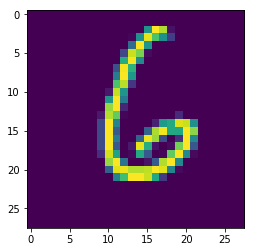

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Final accuracy result: 90.53000211715698 %
Final accuracy result: 10.279999673366547 %
Final accuracy result: 94.60999965667725 %
Number of params of the model 79510
Epoch 1/1
10000/10000 [==============================] - 0s 17us/step
Final accuracy result: 92.33 %
Network containts following layers:
Layer 0 : ('input_1', <tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>)
Layer 1 : ('Conv1_pad', <tf.Tensor 'Conv1_pad/Pad:0' shape=(?, 225, 225, 3) dtype=float32>)
Layer 2 : ('Conv1', <tf.Tensor 'Conv1/convolution:0' shape=(?, 112, 112, 32) dtype=float32>)
Layer 3 : ('bn_Conv1', <tf.Tensor 'bn_Conv1/cond/Merge:0' shape=(?, 112, 112, 32) dtype=float32>)
Layer 4 : ('Conv1_relu', <tf.Tensor 'Conv1_relu/Relu6:0' shape=(?, 112, 112, 32) dtype=float32>)
Layer 5 : ('expanded_conv_depthwise', <tf.Tensor 'expanded_conv_depthwise/depthwise:0' shape=(?, 112, 112, 32) dt

Predicted class: [('n02489166', 'proboscis_monkey', 0.9579257), ('n02487347', 'macaque', 0.004297563), ('n02488291', 'langur', 0.001003495), ('n02483362', 'gibbon', 0.00088702055), ('n02493509', 'titi', 0.00086693815)]


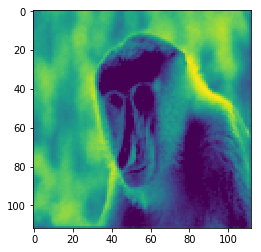

In [3]:
main()